# 03-Time Series Forecasting: Solution 1 

### - 구간평균법 
### - 단순지수평활법 
### - 이중지수평활법
### - 홀트-윈터지수평활법 

### 1. 모듈 불러오기

In [1]:
import os
import itertools

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

from sklearn.datasets import fetch_openml
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import seaborn as sns

!git clone https://github.com/hansam95/LG-Elec-Day3.git

/tmp/ipykernel_1148565/1363980939.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### 2. 데이터 불러오기

In [2]:
# Google trend에서 2012년부터 2022년까지 10년간 '데이터분석 ' 키워드 관심도 변화량
# https://trends.google.com/trends/explore?date=2012-01-01%202022-01-01&geo=KR&q=%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D
data = pd.read_csv('/content/LG-Elec-Day3/data/googletrend_keyword.csv')
data

,카테고리: 모든 카테고리
월,데이터분석: (대한민국)
2012-01,3
2012-02,15
2012-03,9
2012-04,0
...,...
2021-09,93
2021-10,78
2021-11,69
2021-12,71


#### 2.1 Data Preprocessing

In [3]:
# change column name
data = data.rename(columns={'카테고리: 모든 카테고리': 'data_analysis(korea)'})
data = data[1:]

In [6]:
# change the column type to numeric
data = data.astype(np.int64(data['data_analysis(korea)']))

In [7]:
# change the index type to datetime
data.index = pd.to_datetime(data.index)
data.index

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01',
               ...
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01'],
              dtype='datetime64[ns]', length=121, freq=None)

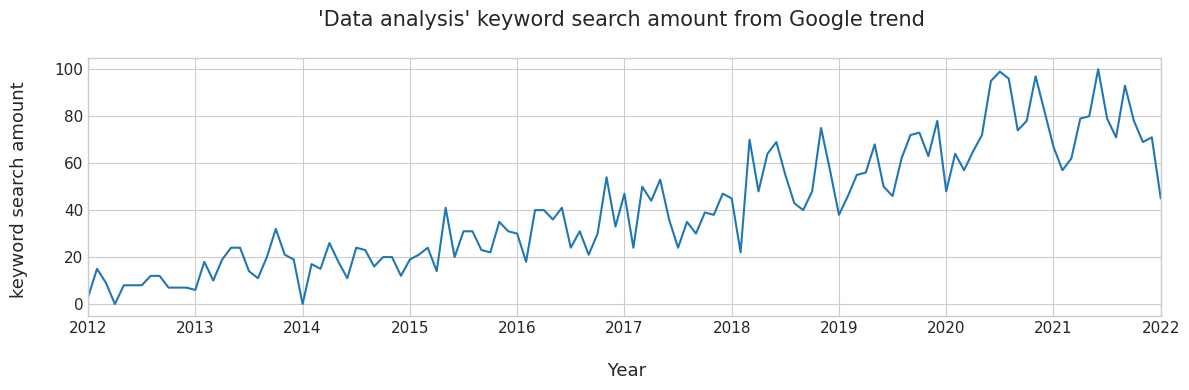

In [8]:
'''
데이터 시각화를 통해 전체 개요 확인
'''
data.plot(figsize=(12,4)) # color='green', linestyle='--', linewidth=1

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend('')

plt.title("'Data analysis' keyword search amount from Google trend \n", fontsize=15)
plt.xlabel('\n Year', fontsize=13)
plt.ylabel('keyword search amount \n', fontsize=13)
plt.tight_layout()
plt.show()

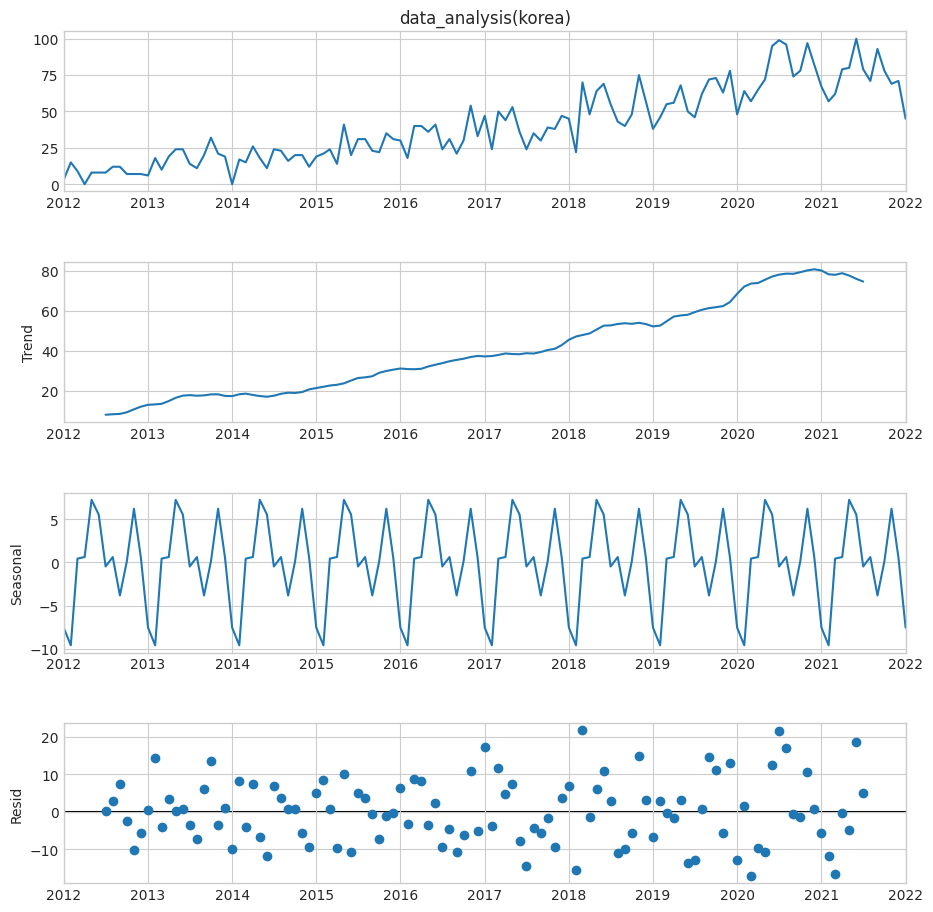

In [9]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

decompostion = sm.tsa.seasonal_decompose(data['data_analysis(korea)'],  model='additive')

fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

In [10]:
'''
Train Test Split
'''
train = data[:'2019-12']
test  = data['2020-01':]

### 3. Moving Average (구간평균법)

In [11]:
'''
Version 1
'''
def Moving_Average(x, N):
    x = x.values.flatten()
    
    pred = np.convolve(x, np.ones(N) / float(N), 'valid')
    pred = np.concatenate((np.zeros(N-1), pred), axis=0)
    pred[:N-1] = np.nan
    return pred

MA_train_pred = pd.DataFrame(Moving_Average(train, 5), index=train.index, columns=['MA_5'])
MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])

print('Moving Average Train results')
print(MA_train_pred)
print('-'*30)
print('Moving Average Test results')
print(MA_test_pred)

Moving Average Train results
            MA_5
2012-01-01   NaN
2012-02-01   NaN
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   7.0
...          ...
2019-08-01  56.4
2019-09-01  59.6
2019-10-01  60.6
2019-11-01  63.2
2019-12-01  69.6

[96 rows x 1 columns]
------------------------------
Moving Average Test results
            MA_5
2020-01-01  69.6
2020-02-01  69.6
2020-03-01  69.6
2020-04-01  69.6
2020-05-01  69.6
2020-06-01  69.6
2020-07-01  69.6
2020-08-01  69.6
2020-09-01  69.6
2020-10-01  69.6
2020-11-01  69.6
2020-12-01  69.6
2021-01-01  69.6
2021-02-01  69.6
2021-03-01  69.6
2021-04-01  69.6
2021-05-01  69.6
2021-06-01  69.6
2021-07-01  69.6
2021-08-01  69.6
2021-09-01  69.6
2021-10-01  69.6
2021-11-01  69.6
2021-12-01  69.6
2022-01-01  69.6


In [12]:
'''
Version 2
'''
MA_train_pred = train.rolling(5).mean() # Option: min_periods=1
MA_train_pred.columns = ['MA_5']

MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])
prediction = pd.concat([MA_train_pred, MA_test_pred], axis=0)

print('Moving Average Train Results')
print(MA_train_pred)
print('-'*30)
print('Moving Average Test Results')
print(MA_test_pred)

Moving Average Train Results
            MA_5
2012-01-01   NaN
2012-02-01   NaN
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   7.0
...          ...
2019-08-01  56.4
2019-09-01  59.6
2019-10-01  60.6
2019-11-01  63.2
2019-12-01  69.6

[96 rows x 1 columns]
------------------------------
Moving Average Test Results
            MA_5
2020-01-01  69.6
2020-02-01  69.6
2020-03-01  69.6
2020-04-01  69.6
2020-05-01  69.6
2020-06-01  69.6
2020-07-01  69.6
2020-08-01  69.6
2020-09-01  69.6
2020-10-01  69.6
2020-11-01  69.6
2020-12-01  69.6
2021-01-01  69.6
2021-02-01  69.6
2021-03-01  69.6
2021-04-01  69.6
2021-05-01  69.6
2021-06-01  69.6
2021-07-01  69.6
2021-08-01  69.6
2021-09-01  69.6
2021-10-01  69.6
2021-11-01  69.6
2021-12-01  69.6
2022-01-01  69.6


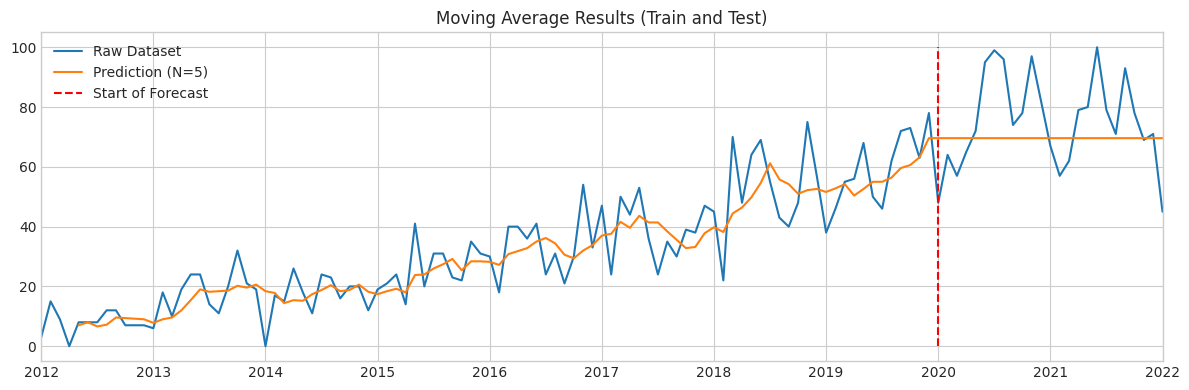

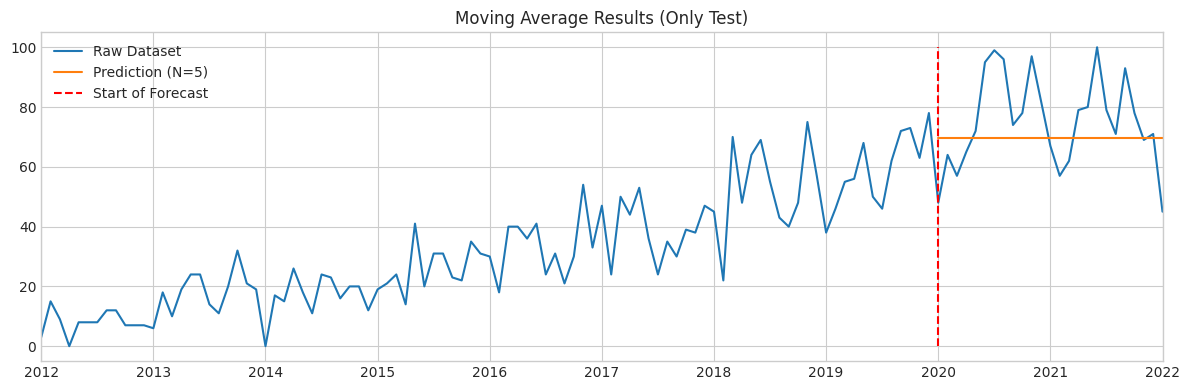

In [13]:
'''
Visualization 
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
prediction.plot(ax=ax, label = 'Prediction (N=5)') #ax 로 하나의 plot에 표현
ax.vlines(test.index[0], 0, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (N=5)', 'Start of Forecast'], loc='upper left')
plt.title('Moving Average Results (Train and Test)')
plt.tight_layout()
plt.show()

# Only Test
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
MA_test_pred.plot(ax=ax, label = 'Prediction (N=5)')
ax.vlines(test.index[0], 0, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (N=5)', 'Start of Forecast'], loc='upper left')
plt.title('Moving Average Results (Only Test)')
plt.tight_layout()
plt.show()

##### 정량적 지표를 통한 모델 검증

###### Mean Squared Error (평균 제곱 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$   

In [14]:
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')

MSE: 261.78


######  Root Mean Squared Error (제곱근 평균 제곱 오차) <br>
$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}}$

In [15]:
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')

RMSE: 16.18


##### Mean Absolute Error (평균 절대 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$

In [16]:
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')

MAE: 12.91


#####  R squared (결정계수 $({r})^{2}$) <br>
$\frac{SSR}{SST} = 1- \frac{SSR}{SST}%$

In [17]:
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

R2 score: -0.13


### 4. Exponential Smoothing (지수평활법)

#### 4.1 Simple Exponential Smoothing (단순지수평활법)

In [18]:
L_0 = np.mean(train)  # initial value

SES_train = train.copy()
SES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['data_analysis(korea)']), SES_train])
SES_train['Level'] = np.nan
SES_train['Forecast'] = np.nan
SES_train.loc[0,'Level'] = L_0.values

SES_train

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,data_analysis(korea),Level,Forecast
0,0.0,31.625,NaN
2012-01-01 00:00:00,3.0,NaN,NaN
2012-02-01 00:00:00,15.0,NaN,NaN
2012-03-01 00:00:00,9.0,NaN,NaN
2012-04-01 00:00:00,0.0,NaN,NaN
...,...,...,...
2019-08-01 00:00:00,62.0,NaN,NaN
2019-09-01 00:00:00,72.0,NaN,NaN
2019-10-01 00:00:00,73.0,NaN,NaN
2019-11-01 00:00:00,63.0,NaN,NaN


In [19]:
'''
Version 1
'''
def Simple_Exponential_Smoothing(table, alpha):
    # table = SES_train.copy()
    # alpha = 0.9
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'data_analysis(korea)']
        L_prev = table.loc[list(table.index)[i-1],'Level']
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev)

        L_pred = table.iloc[-1,1]
        SES_test_pred = [L_pred]*len(test)
        SES_test_pred = pd.DataFrame(SES_test_pred, index=test.index, columns=[f'SES_{alpha}'])
        
    return table, SES_test_pred

In [20]:
SES_train_pred, SES_test_pred = Simple_Exponential_Smoothing(SES_train, 0.9)

In [21]:
print('Simple Exponential Smoothing Train Results')
print(SES_train_pred)
print('-'*30)
print('Simple Exponential Smoothing Test results')
print(SES_test_pred)

Simple Exponential Smoothing Train Results
                     data_analysis(korea)      Level  Forecast
0                                     0.0  31.625000       NaN
2012-01-01 00:00:00                   3.0   5.862500       NaN
2012-02-01 00:00:00                  15.0  14.086250       NaN
2012-03-01 00:00:00                   9.0   9.508625       NaN
2012-04-01 00:00:00                   0.0   0.950862       NaN
...                                   ...        ...       ...
2019-08-01 00:00:00                  62.0  60.456780       NaN
2019-09-01 00:00:00                  72.0  70.845678       NaN
2019-10-01 00:00:00                  73.0  72.784568       NaN
2019-11-01 00:00:00                  63.0  63.978457       NaN
2019-12-01 00:00:00                  78.0  76.597846       NaN

[97 rows x 3 columns]
------------------------------
Simple Exponential Smoothing Test results
              SES_0.9
2020-01-01  76.597846
2020-02-01  76.597846
2020-03-01  76.597846
2020-04-01  76.59

In [22]:
'''
Version 2
'''

SES_train_pred_09 = pd.concat([pd.DataFrame([L_0], columns=['data_analysis(korea)']), train]).ewm(alpha=0.9, adjust=False).mean().iloc[1:] #mean?
SES_train_pred_09.columns = ['SES_09']
SES_test_pred_09 = pd.DataFrame(np.array([SES_train_pred_09.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_09'])
prediction_09 = pd.concat([SES_train_pred_09, SES_test_pred_09], axis=0)

SES_train_pred_05 = pd.concat([pd.DataFrame([L_0], columns=['data_analysis(korea)']), train]).ewm(alpha=0.5, adjust=False).mean().iloc[1:]
SES_train_pred_05.columns = ['SES_05']
SES_test_pred_05 = pd.DataFrame(np.array([SES_train_pred_05.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_05'])
prediction_05 = pd.concat([SES_train_pred_05, SES_test_pred_05], axis=0)

SES_train_pred_01 = pd.concat([pd.DataFrame([L_0], columns=['data_analysis(korea)']), train]).ewm(alpha=0.1, adjust=False).mean().iloc[1:]
SES_train_pred_01.columns = ['SES_01']
SES_test_pred_01 = pd.DataFrame(np.array([SES_train_pred_01.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_01'])
prediction_01 = pd.concat([SES_train_pred_01, SES_test_pred_01], axis=0)

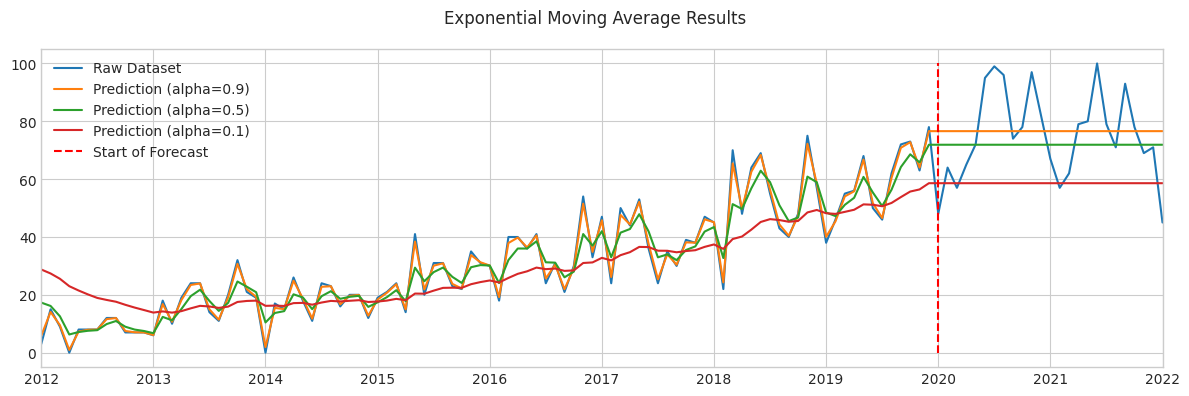

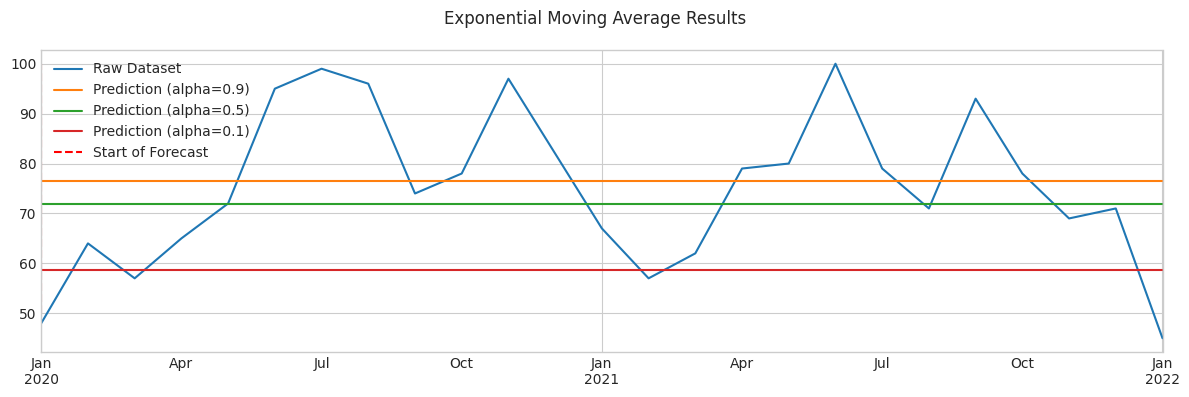

In [23]:
'''
Visualization 
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
prediction_09.plot(ax=ax, label = 'Prediction (alpha=0.9)')
prediction_05.plot(ax=ax, label = 'Prediction (alpha=0.5)')
prediction_01.plot(ax=ax, label = 'Prediction (alpha=0.1)')

ax.vlines(test.index[0], 0, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (alpha=0.9)', 'Prediction (alpha=0.5)', 'Prediction (alpha=0.1)', 'Start of Forecast'], loc='upper left')
plt.suptitle('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

# Only Test
fig, ax = plt.subplots(figsize=(12,4))
data['2020-01':'2022-01'].plot(ax=ax)
prediction_09['2020-01':'2022-01'].plot(ax=ax, label = 'Prediction (alpha=0.9)')
prediction_05['2020-01':'2022-01'].plot(ax=ax, label = 'Prediction (alpha=0.5)')
prediction_01['2020-01':'2022-01'].plot(ax=ax, label = 'Prediction (alpha=0.1)')

ax.vlines(test.index[0], 50, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (alpha=0.9)', 'Prediction (alpha=0.5)', 'Prediction (alpha=0.1)', 'Start of Forecast'], loc='upper left')
plt.suptitle('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

#### 4.2 Double Exponential Smoothing (이중지수평활법)

In [24]:
'''
Searching Initialization Points
'''
train_reg = train.reset_index()
x = np.array(train_reg.index)
y = train_reg['data_analysis(korea)']

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()

print(results.summary())
L_0, B_0 = results.params

                             OLS Regression Results                             
Dep. Variable:     data_analysis(korea)   R-squared:                       0.761
Model:                              OLS   Adj. R-squared:                  0.758
Method:                   Least Squares   F-statistic:                     299.1
Date:                  Wed, 01 Feb 2023   Prob (F-statistic):           5.89e-31
Time:                          18:01:29   Log-Likelihood:                -351.01
No. Observations:                    96   AIC:                             706.0
Df Residuals:                        94   BIC:                             711.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9794      1.918

In [25]:
DES_train = train.copy()
DES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['data_analysis(korea)']), DES_train])
DES_train['Level'] = np.nan
DES_train['Trend'] = np.nan
DES_train['Forecast'] = np.nan

DES_train.loc[0,'Level'] = L_0
DES_train.loc[0,'Trend'] = B_0

DES_train

,data_analysis(korea),Level,Trend,Forecast
0,0.0,2.979381,0.603066,NaN
2012-01-01 00:00:00,3.0,NaN,NaN,NaN
2012-02-01 00:00:00,15.0,NaN,NaN,NaN
2012-03-01 00:00:00,9.0,NaN,NaN,NaN
2012-04-01 00:00:00,0.0,NaN,NaN,NaN
...,...,...,...,...
2019-08-01 00:00:00,62.0,NaN,NaN,NaN
2019-09-01 00:00:00,72.0,NaN,NaN,NaN
2019-10-01 00:00:00,73.0,NaN,NaN,NaN
2019-11-01 00:00:00,63.0,NaN,NaN,NaN


In [26]:
def Double_Exponential_Smoothing(table, alpha, beta):
    # table = DES_train.copy()
    # alpha = 0.16
    # beta = 0.1
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'data_analysis(korea)']
        L_prev = table.loc[list(table.index)[i-1],'Level']
        T_prev = table.loc[list(table.index)[i-1],'Trend']
        
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev+T_prev)
        table.loc[list(table.index)[i],'Trend'] = beta*(table.loc[list(table.index)[i],'Level']-L_prev) + (1-beta)*(T_prev)

        L_Pred = table.iloc[-1,1]
        T_Pred = table.iloc[-1,2]
        
        DES_test_pred = L_Pred + range(len(test))*T_Pred
        DES_test_pred = pd.DataFrame(DES_test_pred, index = test.index, columns=['DES'])
        
    return table, DES_test_pred

In [27]:
DES_train_pred, DES_test_pred = Double_Exponential_Smoothing(DES_train, 0.16, 0.1)

In [28]:
print('Double Exponential Smoothing Train Results')
print(DES_train_pred)
print('-'*30)
print('Double Exponential Smoothing Test results')
print(DES_test_pred)

Double Exponential Smoothing Train Results
                     data_analysis(korea)      Level     Trend  Forecast
0                                     0.0   2.979381  0.603066       NaN
2012-01-01 00:00:00                   3.0   3.489256  0.593747       NaN
2012-02-01 00:00:00                  15.0   5.829722  0.768418       NaN
2012-03-01 00:00:00                   9.0   6.982438  0.806848       NaN
2012-04-01 00:00:00                   0.0   6.543000  0.682220       NaN
...                                   ...        ...       ...       ...
2019-08-01 00:00:00                  62.0  57.562701  0.545583       NaN
2019-09-01 00:00:00                  72.0  60.330958  0.767850       NaN
2019-10-01 00:00:00                  73.0  63.002999  0.958269       NaN
2019-11-01 00:00:00                  63.0  63.807466  0.942889       NaN
2019-12-01 00:00:00                  78.0  66.870298  1.154883       NaN

[97 rows x 4 columns]
------------------------------
Double Exponential Smoothin

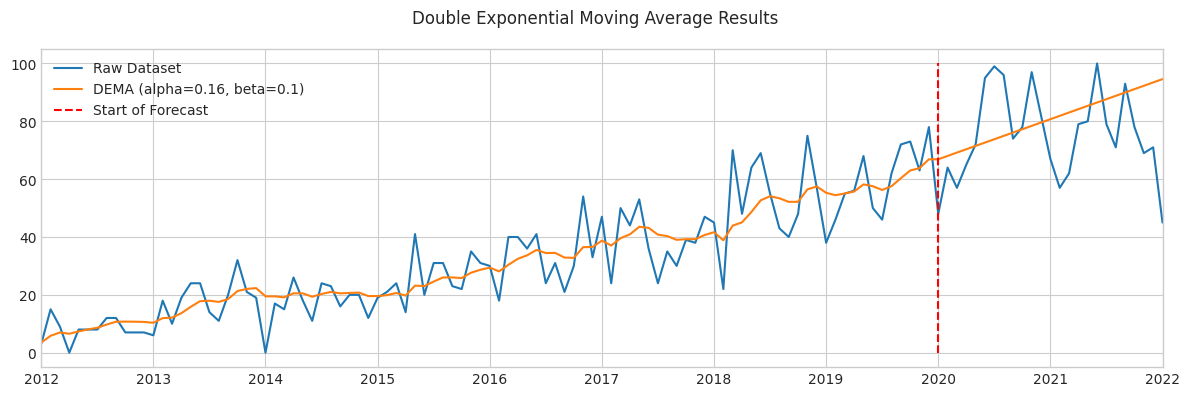

In [37]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(DES_train_pred.iloc[1:,1])
train_pred.columns = ['DES']
DES_pred = pd.concat([train_pred, DES_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
DES_pred.plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
ax.vlines(test.index[0], 0, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'DEMA (alpha=0.16, beta=0.1)', 'Start of Forecast'], loc='upper left')
plt.suptitle('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [38]:
'''
Quantitative Evaluation
'''
print('-'*30)
print('alpha  = 0.16, beta = 0.1')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

------------------------------
alpha  = 0.16, beta = 0.1
MSE: 321.96
RMSE: 17.94
MAE: 14.2
R2 score: -0.39


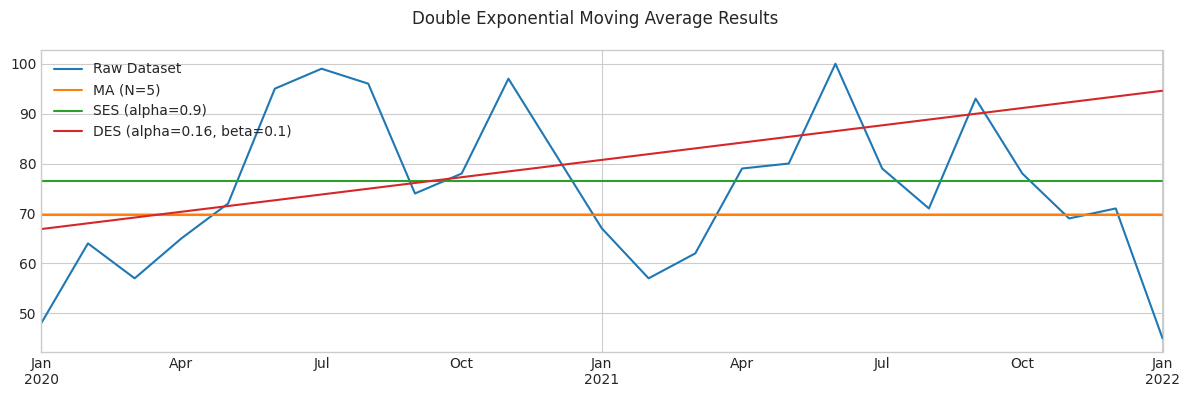

In [30]:
'''
Comparing
'''
fig, ax = plt.subplots(figsize=(12,4))
data['2020-01':].plot(ax=ax)
MA_test_pred['2020-01':].plot(ax=ax, label = 'Prediction (N=5)')
SES_test_pred_09['2020-01':].plot(ax=ax, label = 'Prediction (alpha=0.9)')
DES_test_pred['2020-01':].plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
ax.legend(['Raw Dataset', 'MA (N=5)', 'SES (alpha=0.9)', 'DES (alpha=0.16, beta=0.1)'], loc='upper left')
plt.suptitle('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

#### 4.3 Holt-Winter's Exponential Smoothing (홀트-윈터 지수평활법)

##### 4.3.1 Additive Winter's method

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
HW_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True)
HW_model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,data_analysis(korea),No. Observations:,96
Model:,ExponentialSmoothing,SSE,6876.105
Optimized:,True,AIC,442.060
Trend:,Additive,BIC,483.090
Seasonal:,Additive,AICC,450.943
Seasonal Periods:,12,Date:,"Wed, 01 Feb 2023"
Box-Cox:,False,Time:,18:01:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0657456,alpha,True
smoothing_trend,0.0657455,beta,True


In [32]:
HW_train_pred = HW_model.fittedvalues
HW_test_pred = HW_model.forecast(len(test))
HW_test_pred = pd.DataFrame(HW_test_pred, index=test.index, columns=['HW_add'])

print('Holt-Winter Exponential Smoothing Train Results')
print(HW_train_pred)
print('-'*30)
print('Holt-Winter Smoothing Test results')
print(HW_test_pred)

Holt-Winter Exponential Smoothing Train Results
2012-01-01     1.842209
2012-02-01     0.874666
2012-03-01    13.190689
2012-04-01     9.529568
2012-05-01    16.846369
                ...    
2019-08-01    55.966372
2019-09-01    54.697824
2019-10-01    60.615053
2019-11-01    66.882687
2019-12-01    63.184132
Length: 96, dtype: float64
------------------------------
Holt-Winter Smoothing Test results
               HW_add
2020-01-01  59.621420
2020-02-01  59.041079
2020-03-01  70.830691
2020-04-01  67.865470
2020-05-01  76.270369
2020-06-01  69.920375
2020-07-01  66.065493
2020-08-01  69.080724
2020-09-01  67.591072
2020-10-01  72.471551
2020-11-01  77.972187
2020-12-01  74.592943
2021-01-01  70.056152
2021-02-01  69.475812
2021-03-01  81.265423
2021-04-01  78.300202
2021-05-01  86.705102
2021-06-01  80.355108
2021-07-01  76.500225
2021-08-01  79.515456
2021-09-01  78.025804
2021-10-01  82.906283
2021-11-01  88.406920
2021-12-01  85.027676
2022-01-01  80.490885


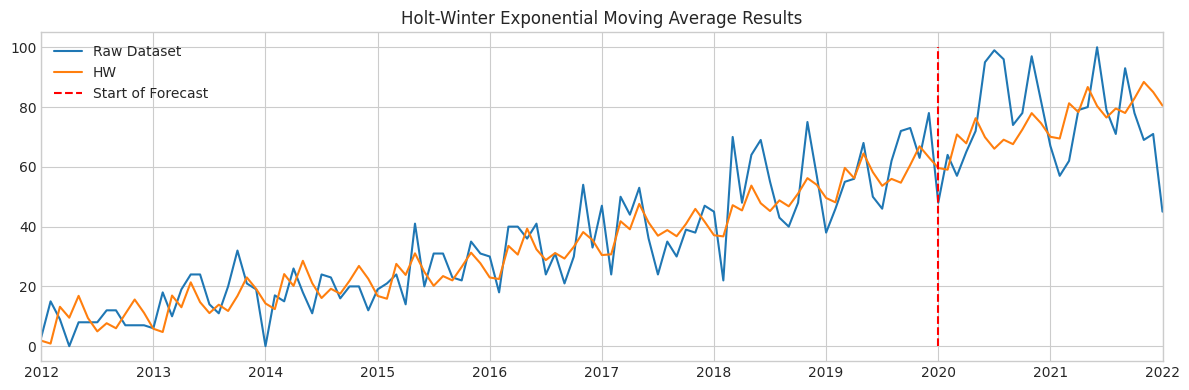

In [33]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(HW_train_pred, columns=['HW_add'])
HW_add_pred = pd.concat([train_pred, HW_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
HW_add_pred.plot(ax=ax, label = 'Prediction')
ax.vlines(test.index[0], 0, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'HW', 'Start of Forecast'], loc='upper left')
plt.title('Holt-Winter Exponential Moving Average Results')
plt.tight_layout()
plt.show()

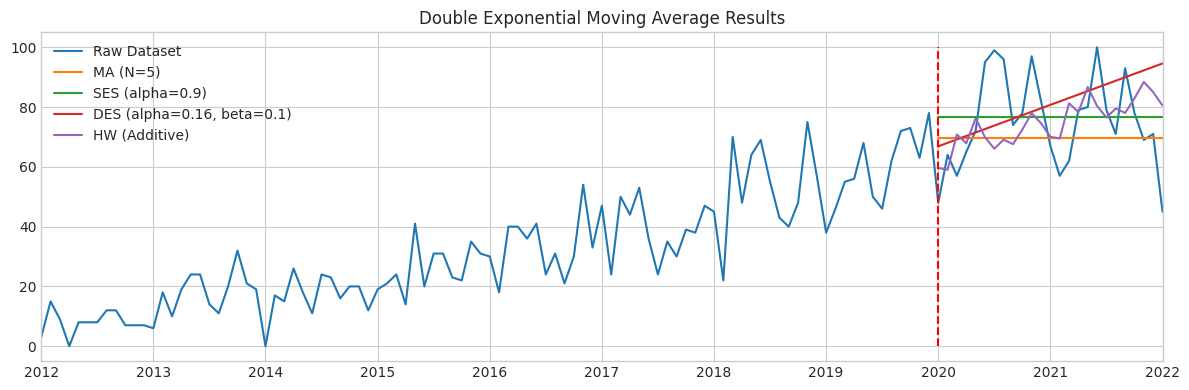

In [34]:
'''
Comparing
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
MA_test_pred['2020-01':].plot(ax=ax, label = 'Prediction (N=5)')
SES_test_pred_09['2020-01':].plot(ax=ax, label = 'Prediction (alpha=0.9)')
DES_test_pred['2020-01':].plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
HW_test_pred['2020-01':].plot(ax=ax, label = 'Prediction (additive)')
ax.vlines(test.index[0], 0, 100, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'MA (N=5)', 'SES (alpha=0.9)', 'DES (alpha=0.16, beta=0.1)', 'HW (Additive)'], loc='upper left')
plt.title('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [35]:
'''
Quantitative Evaluation
'''
print('-'*55)
print('Moving Average (N = 5)')
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')

print('-'*55)
print('Simple Exponential Smoothing (alpha = 0.9)')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')

print('-'*55)
print('Double Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')

print('-'*55)
print('Additive Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_test_pred), 2)}')

-------------------------------------------------------
Moving Average (N = 5)
MSE: 261.78
RMSE: 16.18
MAE: 12.91
-------------------------------------------------------
Simple Exponential Smoothing (alpha = 0.9)
MSE: 233.49
RMSE: 15.28
MAE: 12.42
-------------------------------------------------------
Double Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 321.96
RMSE: 17.94
MAE: 14.2
-------------------------------------------------------
Additive Holt-Winter Exponential Smoothing
MSE: 257.27
RMSE: 16.04
MAE: 12.9


In [36]:
test_predict_results = pd.concat([test, MA_test_pred, SES_test_pred_09, DES_test_pred, HW_test_pred], axis=1)
test_predict_results

,data_analysis(korea),MA_5,SES_09,DES,HW_add
2020-01-01,48,69.6,76.597846,66.870298,59.621420
2020-02-01,64,69.6,76.597846,68.025182,59.041079
2020-03-01,57,69.6,76.597846,69.180065,70.830691
2020-04-01,65,69.6,76.597846,70.334948,67.865470
2020-05-01,72,69.6,76.597846,71.489832,76.270369
2020-06-01,95,69.6,76.597846,72.644715,69.920375
2020-07-01,99,69.6,76.597846,73.799599,66.065493
2020-08-01,96,69.6,76.597846,74.954482,69.080724
2020-09-01,74,69.6,76.597846,76.109366,67.591072
2020-10-01,78,69.6,76.597846,77.264249,72.471551


# EOD